# Installing and loading Dependencies

In [1]:
#install ta-lab
!wget https://launchpad.net/~mario-mariomedina/+archive/ubuntu/talib/+files/libta-lib0_0.4.0-oneiric1_amd64.deb -qO libta.deb
!wget https://launchpad.net/~mario-mariomedina/+archive/ubuntu/talib/+files/ta-lib0-dev_0.4.0-oneiric1_amd64.deb -qO ta.deb
!dpkg -i libta.deb ta.deb
!pip install ta-lib
import talib

Selecting previously unselected package libta-lib0.
(Reading database ... 144433 files and directories currently installed.)
Preparing to unpack libta.deb ...
Unpacking libta-lib0 (0.4.0-oneiric1) ...
Selecting previously unselected package ta-lib0-dev.
Preparing to unpack ta.deb ...
Unpacking ta-lib0-dev (0.4.0-oneiric1) ...
Setting up libta-lib0 (0.4.0-oneiric1) ...
Setting up ta-lib0-dev (0.4.0-oneiric1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Processing triggers for libc-bin (2.27-3ubuntu1) ...
/sbin/ldconfig.real: /usr/local/lib/python3.6/dist-packages/ideep4py/lib/libmkldnn.so.0 is not a symbolic link

     |████████████████████████████████| 266kB 2.8MB/s 
  Created wheel for ta-lib: filename=TA_Lib-0.4.18-cp36-cp36m-linux_x86_64.whl size=1531843 sha256=4426839d8db9c3bea3b876c01814571d6f3dcb5d489fc105017361930c5b4f93
  Stored in directory: /root/.cache/pip/wheels/11/cc/88/20dc42c28a07efb297dad4303948ef6dd4a3c7257553db8f09
Successfully built ta-lib


In [0]:
PAIRS_LIST        = ["EURUSD", "USDJPY", "EURJPY"] #, "USDCHF", "EURCHF"] #, "AUDUSD" ]
PREDICTING_PAIR   = "EURUSD" 
PREDICTING_COLUMN = "close"
PREDICTING_STEP   = 1  # next 15min
LOOK_BACK         = 32 # 32 * 15min = 8 hour
SPLIT             = 0.9 # data split ration for training and testing
DATA_PATH          = "/content/drive/My Drive/Colab Notebooks/data/"
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
#for dirname, _, filenames in os.walk(DATA_PATH):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

In [3]:
# import libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Input, LSTM, Dense, Flatten
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import TensorBoard
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA, KernelPCA
import plotly.graph_objects as go
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Used TA-Lib for creating additional features. More on this later.
from talib.abstract import *
from talib import MA_Type
import datetime
# loading data
data = {}
for pair_name in PAIRS_LIST:
    data[pair_name] = pd.read_csv(DATA_PATH+pair_name+"-2000-2020-15m.csv")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [0]:
# normalize data shape and format
def norm_data_shape_format(df):
    orig_cols = ["DATE_TIME", "OPEN", "HIGH", "LOW", "CLOSE"]
    cols_name = ["timestamp", "open", "high", "low", "close"]
    df.rename(columns=dict(zip(orig_cols, cols_name)), inplace=True)
    df['timestamp'] = pd.to_datetime(df['timestamp'], infer_datetime_format=True, errors='coerce')
    df.set_index("timestamp", inplace=True)
    df = df.reindex(columns=cols_name[1:])
    return df.astype(float)
    
for key in data:
    data[key] = norm_data_shape_format(data[key])

In [5]:
data["EURUSD"].head()

,open,high,low,close
timestamp,,,,
2000-01-03 00:00:00,1.0073,1.0080,1.0073,1.0077
2000-01-03 00:15:00,1.0078,1.0087,1.0076,1.0086
2000-01-03 00:30:00,1.0087,1.0089,1.0079,1.0079
2000-01-03 00:45:00,1.0078,1.0132,1.0078,1.0128
2000-01-03 01:00:00,1.0129,1.0133,1.0120,1.0122


In [0]:
def extract_features(df):
    df['hour'] = df.index.hour
    df['day']  = df.index.weekday
    df['week'] = df.index.week
    # df['volume'] = pd.to_numeric(df['volume'])
    df['close']  = pd.to_numeric(df['close'])
    df['open']   = pd.to_numeric(df['open'])
    # df['momentum']   = df['volume'] * (df['open'] - df['close'])
    df['avg_price']  = (df['low'] + df['high'])/2
    df['range']      = df['high'] - df['low']
    df['ohlc_price'] = (df['low'] + df['high'] + df['open'] + df['close'])/4
    df['oc_diff']      = df['open'] - df['close']
    # df['spread_open']  = df['ask_open'] - df['bid_open']
    # df['spread_close'] = df['ask_close'] - df['bid_close']
    inputs = {
        'open'   : df['open'].values,
        'high'   : df['high'].values,
        'low'    : df['low'].values,
        'close'  : df['close'].values,
        'volume' : np.zeros(df['close'].shape[0]) # for sake of using TA lib
    }
    df['ema'] = MA(inputs, timeperiod=15, matype=MA_Type.T3)
    df['bear_power'] = df['low'] - df['ema']
    df['bull_power'] = df['high'] - df['ema']
    # Since computing EMA leave some of the rows empty, we want to remove them. (EMA is a lagging indicator)
    df.dropna(inplace=True)
    # Add 1D PCA vector as a feature as well. This helped increasing the accuracy by adding more variance to the feature set
    pca_input = df.drop('close', axis=1).copy()
    pca_features = pca_input.columns.tolist()
    pca = PCA(n_components=1)
    df['pca'] = pca.fit_transform(pca_input.values.astype('float32'))
    df['rsi'] = RSI(df['close'])
    df['atr'] = ATR(df['high'],df['low'],df['close'])
    df['adx'] = ADX(df['high'],df['low'],df['close'])

columns_order = ["open", "high", "low", "close", "hour", "day", "week", 
                 "avg_price", "range", "ohlc_price", "oc_diff", "ema", "bear_power", "bull_power", "pca"]

In [0]:
for key in data:
    extract_features(data[key])

# Merge All Pairs

In [0]:
# sort and rename column names
def sort_and_rename(df, suffix):
    cols_name = [c + suffix for c in columns_order]    
    df.rename(columns=dict(zip(columns_order,cols_name)), inplace=True)
    df = df.reindex(columns=cols_name, copy=False)
    return df
    
all_columns = [] # to save the correct order of data

for key in PAIRS_LIST:
    data[key] = sort_and_rename(data[key], "_" + key)
    all_columns += list(data[key].columns) # to save the correct order of data

In [0]:
# merge 
merged_data = pd.DataFrame(data[PAIRS_LIST[0]])
for key in PAIRS_LIST[1:]:
    merged_data = merged_data.merge(data[key], how="inner", left_index=True, right_index=True)
    
merged_data = merged_data.reindex(columns=all_columns)

# drop duplicate columns
for key in PAIRS_LIST[1:]:
    merged_data.drop(columns=[
        "hour_"+key,
        "day_" +key,
        "week_"+key,
    ],inplace=True)   
#merged_data.head()

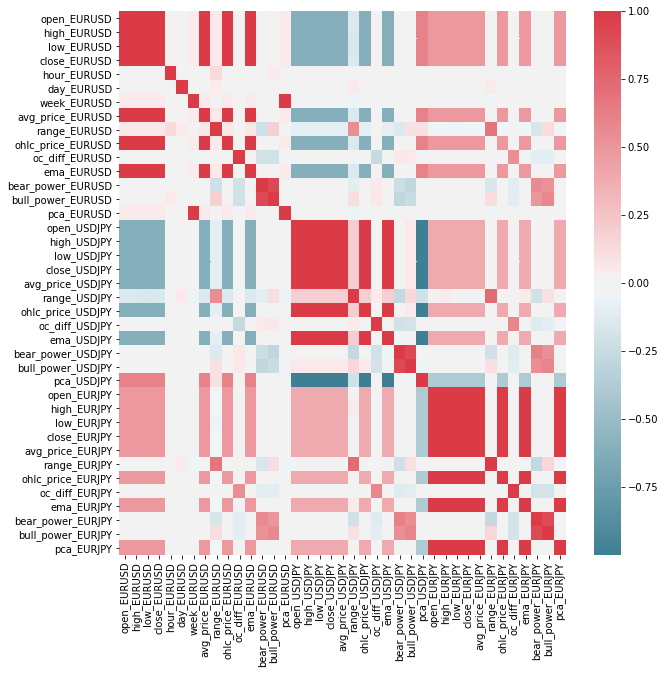

In [10]:
# seeing correlation between columns
corr = merged_data.corr()
mask = np.zeros_like(corr, dtype=np.bool)
f, ax = plt.subplots(figsize=(10, 10))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, ax=ax)

In [0]:
def create_dataset(df, look_back=10):
    dataX, dataY = [], []
    for i in range(len(df)-look_back-1):
        dataX.append(df[i:(i+look_back)])
        dataY.append(df[i + look_back])
    return np.array(dataX), np.array(dataY)

In [0]:
# Scale reshape and group the data
target_column_name = PREDICTING_COLUMN + "_" + PREDICTING_PAIR

# Create scalers
scaler = MinMaxScaler()
scaled = pd.DataFrame(scaler.fit_transform(merged_data), columns=merged_data.columns)

x_scaler = MinMaxScaler(feature_range=(0, 1))
x_scaler = x_scaler.fit(merged_data.values.astype('float32'))
y_scaler = MinMaxScaler(feature_range=(0, 1))
y_scaler = y_scaler.fit(merged_data[target_column_name].values.astype('float32').reshape(-1,1))

# Create dataset
target_index = scaled.columns.tolist().index(target_column_name)
dataset = scaled.values.astype('float32')

X, Ya = create_dataset(dataset, look_back=LOOK_BACK)

In [14]:
Y = Ya[:,target_index]
train_size = int(len(X) * SPLIT)
trainX = X[:train_size]
trainY = Y[:train_size]
testX = X[train_size:]
testY = Y[train_size:]
print(X.shape, Y.shape)
print(trainX.shape, trainY.shape)
print(testX.shape, testY.shape)

(486897, 32, 39) (486897,)
(438207, 32, 39) (438207,)
(48690, 32, 39) (48690,)


In [15]:
def create_model():
    model = Sequential()
    model.add(LSTM(20, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
    model.add(LSTM(20, return_sequences=True))
    model.add(LSTM(10, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(4, return_sequences=False))
    model.add(Dense(4, kernel_initializer='uniform', activation='relu'))
    model.add(Dense(1, kernel_initializer='uniform', activation='relu'))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae', 'mse'])
    print(model.summary())
    return model
model = create_model()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 32, 20)            4800      
_________________________________________________________________
lstm_1 (LSTM)                (None, 32, 20)            3280      
_________________________________________________________________
lstm_2 (LSTM)                (None, 32, 10)            1240      
_________________________________________________________________
dropout (Dropout)            (None, 32, 10)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 4)                 240       
_________________________________________________________________
dense (Dense)                (None, 4)                 20        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5

In [0]:
OUTPUT_BEST_WEIGHT = DATA_PATH+"EURUSD-M15-Prediction-{epoch:02d}-{val_mse:.8f}.hdf5"
# Save the best weight during training.
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import LearningRateScheduler
import tensorflow.keras.backend as K

def scheduler(epoch):
    if epoch%10==0 and epoch!=0:
        lr = K.get_value(model.optimizer.lr)
        K.set_value(model.optimizer.lr, lr*.9)
        print("lr changed to {}".format(lr*.9))
    return K.get_value(model.optimizer.lr)
# To improve the weights towards the global optimal, I retrained the model with LearningRateScheduler added
lr_decay = LearningRateScheduler(scheduler)

# Monitor the trianing progress via TensorBoard
from tensorflow.keras.callbacks import TensorBoard
import datetime
log_dir = "/content/drive/My Drive/Colab Notebooks/log/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard = TensorBoard(log_dir=log_dir)

# create check point based on mse
checkpoint = ModelCheckpoint(OUTPUT_BEST_WEIGHT, monitor='val_mse', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]#, lr_decay, tensorboard]

In [19]:
# Fit
history = model.fit(trainX, trainY, epochs=400, batch_size=512, verbose=1, callbacks=callbacks_list, validation_split=0.1)

Epoch 1/400
771/771 [==============================] - ETA: 0s - loss: 0.0353 - mae: 0.0873 - mse: 0.0353
Epoch 00001: val_mse improved from inf to 0.00014, saving model to /content/drive/My Drive/Colab Notebooks/data/EURUSD-M15-Prediction-01-0.00013660.hdf5
771/771 [==============================] - 28s 36ms/step - loss: 0.0353 - mae: 0.0873 - mse: 0.0353 - val_loss: 1.3660e-04 - val_mae: 0.0108 - val_mse: 1.3660e-04
Epoch 2/400
771/771 [==============================] - ETA: 0s - loss: 2.0412e-04 - mae: 0.0092 - mse: 2.0412e-04
Epoch 00002: val_mse did not improve from 0.00014
771/771 [==============================] - 26s 34ms/step - loss: 2.0412e-04 - mae: 0.0092 - mse: 2.0412e-04 - val_loss: 1.5006e-04 - val_mae: 0.0117 - val_mse: 1.5006e-04
Epoch 3/400
771/771 [==============================] - ETA: 0s - loss: 1.1166e-04 - mae: 0.0071 - mse: 1.1166e-04
Epoch 00003: val_mse improved from 0.00014 to 0.00004, saving model to /content/drive/My Drive/Colab Notebooks/data/EURUSD-M15-Pr

In [20]:
!pip install plotly
import plotly.graph_objects as go
def drawHistory():
  fig = go.Figure()
  for k in sorted (history.history.keys()):
    if 'lr' not in k:
      fig.add_trace(go.Scatter(x=np.arange(1,len(history.history[k])+1), y=history.history[k], name=k))
  fig.show()
drawHistory()

In [22]:
import glob
BestWeightOutput = max(glob.glob(DATA_PATH+"EURUSD-M15-Prediction*"), key=os.path.getctime)
model.load_weights(BestWeightOutput) # load best validation 
history = model.fit(trainX, trainY, epochs=8, batch_size=512, callbacks=callbacks_list, validation_split=0.1)

Epoch 1/8
385/386 [============================>.] - ETA: 0s - loss: 2.6778e-06 - mae: 0.0012 - mse: 2.6778e-06
Epoch 00001: val_mse did not improve from 0.00000
386/386 [==============================] - 16s 41ms/step - loss: 2.6776e-06 - mae: 0.0012 - mse: 2.6776e-06 - val_loss: 7.2072e-07 - val_mae: 5.9046e-04 - val_mse: 7.2072e-07
Epoch 2/8
385/386 [============================>.] - ETA: 0s - loss: 2.3898e-06 - mae: 0.0011 - mse: 2.3898e-06
Epoch 00002: val_mse did not improve from 0.00000
386/386 [==============================] - 16s 41ms/step - loss: 2.3896e-06 - mae: 0.0011 - mse: 2.3896e-06 - val_loss: 9.3110e-07 - val_mae: 7.0775e-04 - val_mse: 9.3110e-07
Epoch 3/8
385/386 [============================>.] - ETA: 0s - loss: 2.5237e-06 - mae: 0.0012 - mse: 2.5237e-06
Epoch 00003: val_mse did not improve from 0.00000
386/386 [==============================] - 16s 41ms/step - loss: 2.5235e-06 - mae: 0.0012 - mse: 2.5235e-06 - val_loss: 1.5556e-06 - val_mae: 0.0010 - val_mse: 1.55

In [0]:
pred = model.predict(testX)

In [0]:
predict_step = pd.DataFrame()
for i in range(pred.shape[1]):
  predict_step[i] = pred[:,i]

In [28]:
fig = go.Figure()
for k in range(pred.shape[1]):
  fig.add_trace(go.Scatter(x=np.arange(1,len(predict_step[k])+1), y=predict_step[k], name='Predicted_Step'+str(k+1)))
  fig.add_trace(go.Scatter(x=np.arange(1,len(predict_step[k])+1), y=testY.reshape(testY.shape[0],1)[:,k], name='Actual_Step'+str(k+1)))
fig.show()

Output hidden; open in https://colab.research.google.com to view.

# Compare the unscaled values and see if the prediction falls within the Low and High

In [0]:
pred = model.predict(testX)

In [0]:
pred = y_scaler.inverse_transform(pred)
close = y_scaler.inverse_transform(np.reshape(testY, (testY.shape[0], 1)))

predictions = pd.DataFrame()
predictions['predicted'] = pd.Series(np.reshape(pred, (pred.shape[0])))
predictions['close'] = pd.Series(np.reshape(close, (close.shape[0])))

In [0]:
p = merged_data[-len(pred):].copy()
predictions.index = p.index
predictions = predictions.astype(float)
predictions = predictions.merge(p[['low_'+PREDICTING_PAIR, 'high_'+PREDICTING_PAIR]], right_index=True, left_index=True)

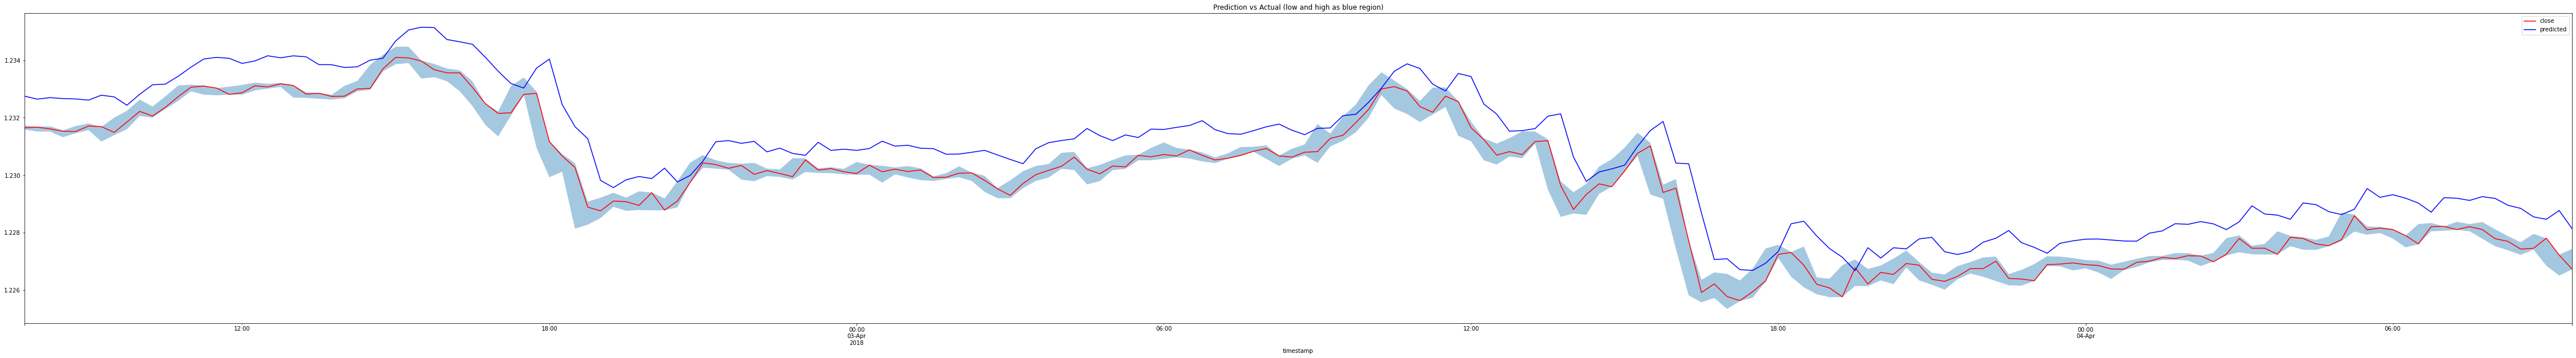

In [54]:
zoom = 200
ax = predictions[:zoom].plot(y='close', c='red', figsize=(80,10))
ax = predictions[:zoom].plot(y='predicted', c='blue', figsize=(80,10), ax=ax)
index = [str(item) for item in predictions[:zoom].index]
plt.fill_between(x=index, y1='low_'+PREDICTING_PAIR, y2='high_'+PREDICTING_PAIR, data=p[:zoom], alpha=0.4)
plt.title('Prediction vs Actual (low and high as blue region)')
plt.show()

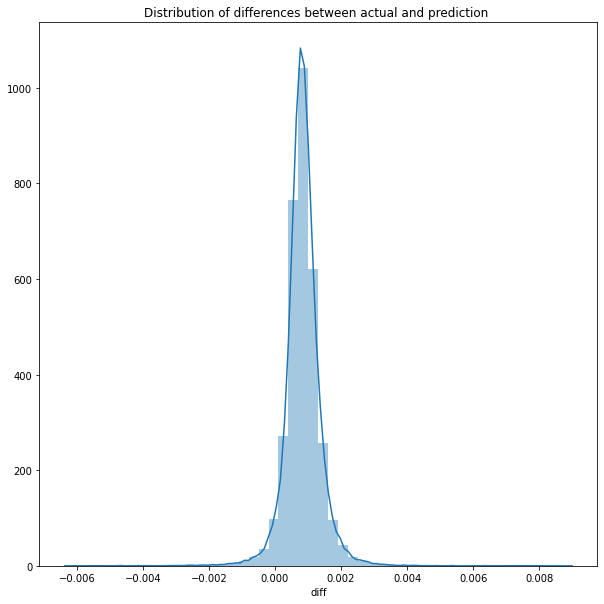

In [35]:
predictions['diff'] = predictions['predicted'] - predictions['close']
plt.figure(figsize=(10,10))
sns.distplot(predictions['diff']);
plt.title('Distribution of differences between actual and prediction ')
plt.show()

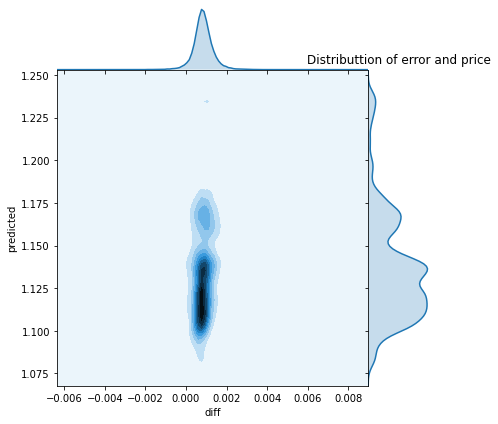

In [36]:
g = sns.jointplot("diff", "predicted", data=predictions, kind="kde", space=0)
plt.title('Distributtion of error and price')
plt.show()

In [0]:
print("MSE : ", mean_squared_error(predictions['predicted'].values, predictions['close'].values))
print("MAE : ", mean_absolute_error(predictions['predicted'].values, predictions['close'].values))
predictions['diff'].describe()

MSE :  7.043465488090678e-07
MAE :  0.0007061225086493423


count    24345.000000
mean        -0.000635
std          0.000549
min         -0.007809
25%         -0.000890
50%         -0.000642
75%         -0.000394
max          0.006562
Name: diff, dtype: float64